<a href="https://colab.research.google.com/github/harnalashok/hadoop/blob/main/Spark_concepts_in_pictures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 16th MArch, 2023

## Some spark concepts

### Overview

At a high level, every Spark application consists of a `driver` program that runs the user’s python program and executes various  operations that may result in parallel tasks on a cluster. The main abstraction Spark provides is a resilient distributed dataset (RDD), which is a collection of elements partitioned across the nodes of the cluster that can be operated on in parallel. RDDs are created by starting with a file in the Hadoop file system (or any other Hadoop-supported file system), and transforming it. Users may also ask Spark to persist an RDD in memory, allowing it to be reused efficiently across parallel operations. Finally, RDDs automatically recover from node failures.

A second abstraction in Spark is shared variables that can be used in parallel operations. For example, in a filter operation, we may filter values > abc, where 'abc' is a variable. By default, when Spark runs a function in parallel as a set of tasks on different nodes, it ships a copy of each variable used in the function to each task. Sometimes, a variable needs to be shared across tasks, or between tasks and the driver program.

### What is lineage in spark?

When a transformation (`map` or `filter` etc.) is called, it is not executed by Spark immediately, instead a lineage is created for each transformation. A lineage will keep track of what all transformations has to be applied on that RDD (as and when the RDD <i>materialises</i>), including the location from where it has to read the data.

Lineage in spark
Refer [here](https://www.usenix.org/system/files/conference/nsdi12/nsdi12-final138.pdf)

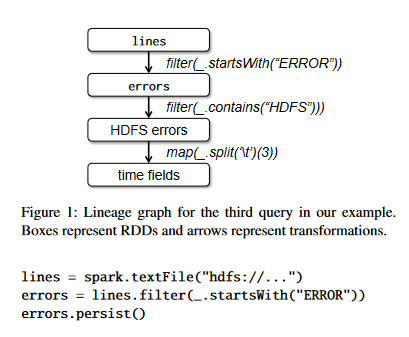

###What is a spark context?<br>
Refer [here](https://sparkbyexamples.com/spark/spark-sparkcontext/)

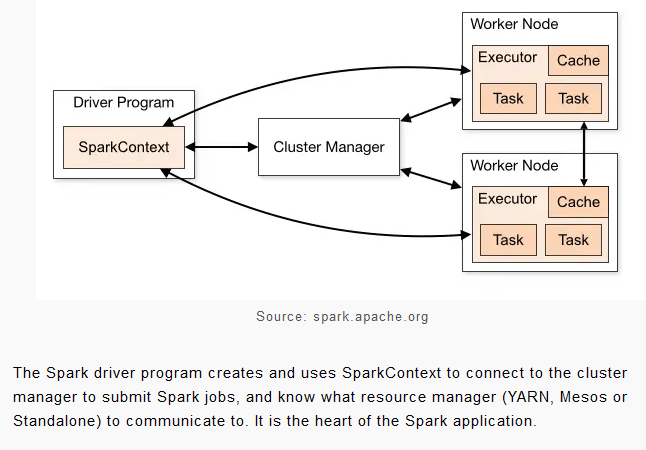

###What is a spark driver?

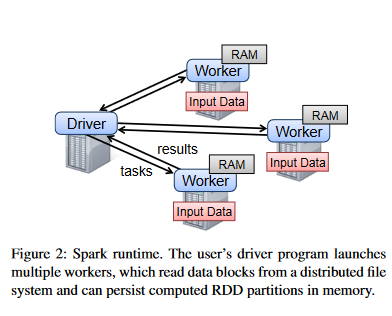

Apache Spark archirecture<br>
Reference [here](https://sparkbyexamples.com/spark/what-is-apache-spark-driver/)

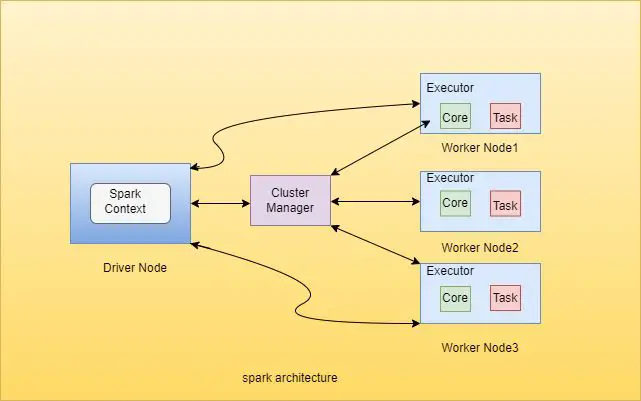

Apache Spark driver

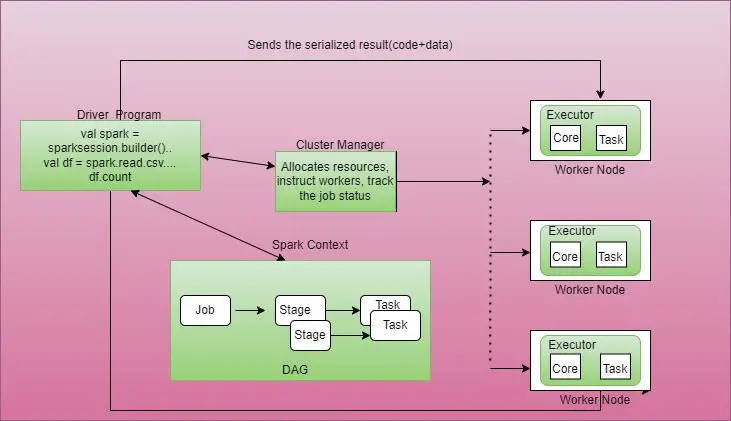

###How is spark context created?

The first thing a Spark program must do is to create a `SparkContext` object, which tells Spark how to access a cluster.<br>
To create a `SparkContext` you first need to build a `SparkConf` object that contains information about your application.

In [ ]:
# 1.0 Build spark conf object:
conf = SparkConf().setAppName(appName).setMaster(master)
# appName: It is a name for your application
#           to show on the cluster UI. 
# master:   It is a Spark, Mesos or YARN cluster URL,
#           or a special “local” string to run in local mode. 

In [ ]:
# 2.0 Create spark context:
sc = SparkContext(conf=conf)

In the PySpark shell, a special interpreter-aware `SparkContext` is already created for you, in the variable called `sc`. Making your own `SparkContext` will not work. <br>
You can set which master the context connects to using the `--master` argument,

In [ ]:
./bin/pyspark --master local[4]

# [4] : Indicates the number of cores that will
#       be assigned to the spark-submit process

### RDD vs lineage

RDDs are immutable distributed collection of elements of your data that can be stored in memory or disk across a cluster of machines. The data is partitioned across machines in your cluster that can be operated in parallel with a low-level API that offers transformations and actions. RDDs are fault tolerant as they track data lineage information to rebuild lost data automatically on failure.<br>
Thus RDDs are data elements while lineage is the history of how that RDD was created.

Parallelized collections are created by calling SparkContext’s parallelize method on an existing iterable or collection in your driver program. The elements of the collection are copied to form a distributed dataset that can be operated on in parallel. For example, here is how to create a parallelized collection holding the numbers 1 to 5:

In [ ]:
data = [1, 2, 3, 4, 5]
distData = sc.parallelize(data)

Once created, the distributed dataset (distData) can be operated on in parallel. For example, we can call `distData.reduce(lambda a, b: a + b)` to add up the elements of the list. We describe operations on distributed datasets later on.

But note that while above statements will operate on RDD only after it is forced to come into existence by an `action` statement. Thus, the following merely constitute `lineage` 

In [ ]:
data = [1, 2, 3, 4, 5]
distData = sc.parallelize(data)
distData.reduce(lambda a, b: a + b)

For example the following statement is forced to write to console. And at that time, each one of the above (two) statements, produce an `immutable` RDD.

In [ ]:
 distData.first()

### RDD operations
Refer [here](https://spark.apache.org/docs/latest/rdd-programming-guide.html)<br>
For list of transformations and actions, see [here](https://spark.apache.org/docs/latest/rdd-programming-guide.html#transformations).

RDDs support two types of operations: `transformations`, which create a new dataset from an existing one, and `actions`, which return a value to the driver program after running a computation on the dataset. For example, `map` is a transformation that passes each dataset element through a function and returns a new RDD representing the results. On the other hand, `reduce` is an action that aggregates all the elements of the RDD using some function and returns the final result to the driver program (although there is also a parallel `reduceByKey` that returns a distributed dataset).

All transformations in Spark are lazy, in that they do not compute their results right away.<br>
**Thus, NO RDDs ARE CREATED right away.**<br>  
Instead, they just remember the transformations applied to some base dataset (e.g. a file). The transformations are only computed when an `action` requires a result to be returned to the driver program. This design enables Spark to run more efficiently. For example, we can realize that a dataset created through `map` will be used in a `reduce` and return only the result of the reduce to the driver, rather than the larger mapped dataset.

To illustrate RDD basics, consider the simple program below:

In [ ]:
lines = sc.textFile("data.txt")
lineLengths = lines.map(lambda s: len(s))
totalLength = lineLengths.reduce(lambda a, b: a + b)

The first line defines a base RDD from an external file. This dataset is not loaded in memory or otherwise acted on: `lines` is merely a pointer to the file. The second line defines `lineLengths` as the result of a `map` transformation. Again, `lineLengths` is not immediately computed, due to laziness. Finally, we run `reduce`, which is an `action`. At this point Spark breaks the computation into tasks to run on separate machines, and each machine runs both its part of the `map` and a local reduction, returning only its answer to the driver program.

If we also wanted to use lineLengths again later, we could add:

In [ ]:
lineLengths.persist() 

before the reduce, which would cause lineLengths to be saved in memory after the first time it is computed.

In [ ]:
################# I am done ####################